In [1]:
import sys
!{sys.executable} -m pip install tqdm

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip available: 22.3.1 -> 23.1.2
[notice] To update, run: pip install --upgrade pip


In [2]:
import os
import random
import math

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from tqdm import tqdm

from skimage.io import imread, imshow, imsave
from skimage.morphology import label, remove_small_objects
from skimage.transform import resize
from skimage.color import rgb2gray
from skimage.filters import threshold_otsu

from scipy.stats import pearsonr
from scipy.ndimage.morphology import distance_transform_edt

from keras.models import Sequential, Model, load_model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import Conv2D, BatchNormalization, Activation, MaxPooling2D, Dropout, Conv2DTranspose, Input, Flatten
from keras.layers import concatenate, add
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from keras.optimizers import Adam, Nadam, SGD

from keras import backend as K
import tensorflow as tf

print('Imports Complete')

/tmp/ipykernel_141046/1137590346.py:22: DeprecationWarning: Please use `distance_transform_edt` from the `scipy.ndimage` namespace, the `scipy.ndimage.morphology` namespace is deprecated.
  from scipy.ndimage.morphology import distance_transform_edt
2023-05-07 13:40:24.618050: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-07 13:40:25.257590: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Imports Complete


In [3]:
print(tf.__version__)
print(tf.config.list_physical_devices())

2.10.0
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


In [4]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  2


In [5]:
tf.test.is_built_with_cuda()

True

In [6]:
if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")

tf.test.gpu_device_name()

Default GPU Device: /device:GPU:0


2023-05-07 13:40:28.525429: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-07 13:40:30.898435: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /device:GPU:0 with 79035 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:07:00.0, compute capability: 8.0
2023-05-07 13:40:30.904000: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /device:GPU:1 with 79098 MB memory:  -> device: 1, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:90:00.0, compute capability: 8.0
2023-05-07 13:40:30.935223: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /device:GPU:0 with 79035 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:0

'/device:GPU:0'

In [7]:
def generate_train_val_test_ids(img_path):

    train_val_ids = next(os.walk(img_path + 'train_val'))[2]
    random.seed(1)
    random.shuffle(train_val_ids)
    num_train_val = len(train_val_ids)
    print('Total number of training and validation: ' + str(num_train_val))
    
    test_ids = next(os.walk(img_path + 'test'))[2]
    test_ids.sort()
    num_test = len(test_ids)
    print('Total number of test: ' + str(num_test))
    
    val_split = 0.2
    split_cutoff = int(num_train_val*(1 - val_split))
    print('Training set = ' + str(split_cutoff) + ' and Validation set = ' + str(num_train_val - split_cutoff))    
    
    return train_val_ids, test_ids, split_cutoff

def get_image_mask_data(img_path, mask_path, train_val_ids, test_ids, IMG_WIDTH=512, IMG_HEIGHT=512, IMG_CHANNELS=3):
    
    # Num of train val test
    num_train_val = len(train_val_ids)
    num_test = len(test_ids)
    
    # Get and resize training and validation set images and masks
    X_train = np.zeros([num_train_val, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS], dtype=np.float32)
    Y_train = np.zeros([num_train_val, IMG_HEIGHT, IMG_WIDTH, 1], dtype=np.bool)
    sys.stdout.flush()
    for n, id_ in tqdm(enumerate(train_val_ids), total=num_train_val):    
        img = imread(img_path + 'train_val/' + id_) / 255.0    
        X_train[n] = img
        mask = imread(mask_path + 'train_val/' + id_.split(".")[0] + '.png')       
        binary = mask > 0    
        Y_train[n] = np.expand_dims(binary,axis=2)    
        
            
    # Get and resize test set images and masks
    X_test = np.zeros([num_test, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS], dtype=np.float32)
    Y_test = np.zeros([num_test, IMG_HEIGHT, IMG_WIDTH, 1], dtype=np.bool)
    sys.stdout.flush()
    for n, id_ in tqdm(enumerate(test_ids), total=num_test):    
        img = imread(img_path + 'test/' + id_) / 255.0    
        X_test[n] = img
        mask = imread(mask_path + 'test/' + id_.split(".")[0] + '.png')       
        binary = mask > 0    
        Y_test[n] = np.expand_dims(binary,axis=2)     
        
    return X_train, Y_train, X_test, Y_test

def get_data_generator(X_train, Y_train, split_cutoff, batch_size=4, seed=42):
    
    # Creating the training Image and Mask generator
    image_datagen = image.ImageDataGenerator(horizontal_flip=True, vertical_flip=True, rotation_range = 90, fill_mode = 'constant', cval = 0)
    mask_datagen = image.ImageDataGenerator(horizontal_flip=True, vertical_flip=True, rotation_range = 90, fill_mode = 'constant', cval = 0)

    # Keep the same seed for image and mask generators so they fit together
    # Creating the training Image and Mask generator
    image_datagen.fit(X_train[:split_cutoff], augment=True, seed=seed)
    mask_datagen.fit(Y_train[:split_cutoff], augment=True, seed=seed)

    x=image_datagen.flow(X_train[:split_cutoff],batch_size=batch_size,shuffle=True, seed=seed)
    y=mask_datagen.flow(Y_train[:split_cutoff],batch_size=batch_size,shuffle=True, seed=seed)

    # Creating the validation Image and Mask generator
    image_datagen_val = image.ImageDataGenerator()
    mask_datagen_val = image.ImageDataGenerator()

    image_datagen_val.fit(X_train[split_cutoff:], augment=True, seed=seed)
    mask_datagen_val.fit(Y_train[split_cutoff:], augment=True, seed=seed)

    x_val=image_datagen_val.flow(X_train[split_cutoff:],batch_size=batch_size,shuffle=True, seed=seed)
    y_val=mask_datagen_val.flow(Y_train[split_cutoff:],batch_size=batch_size,shuffle=True, seed=seed)

    #creating a training and validation generator that generate masks and images
    train_generator = zip(x, y)
    val_generator = zip(x_val, y_val)    
    
    return train_generator, val_generator

In [8]:
smooth = 1.
# Metric function
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def numpy_dice_coef(y_true, y_pred): # Used to calculate on test set later
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    intersection = np.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (np.sum(y_true_f) + np.sum(y_pred_f) + smooth)

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

In [9]:
def conv2d_block(input_tensor, n_filters, kernel_size=3, batchnorm=True, actfun='relu'):

    # first layer
    x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), kernel_initializer="he_normal",
               padding="same")(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation(actfun)(x)
    # second layer
    x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), kernel_initializer="he_normal",
               padding="same")(x)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation(actfun)(x)
    return x

def get_unet(input_img, n_filters=32, dropout=0.5, batchnorm=True, actfun='relu'):
    # contracting path
    c1 = conv2d_block(input_img, n_filters=n_filters*1, kernel_size=3, batchnorm=batchnorm, actfun=actfun)
    p1 = MaxPooling2D((2, 2)) (c1)
    p1 = Dropout(dropout*0.5)(p1)
    print('Contract1')
    c2 = conv2d_block(p1, n_filters=n_filters*2, kernel_size=3, batchnorm=batchnorm, actfun=actfun)
    p2 = MaxPooling2D((2, 2)) (c2)
    p2 = Dropout(dropout)(p2)
    print('Contract2')
    c3 = conv2d_block(p2, n_filters=n_filters*4, kernel_size=3, batchnorm=batchnorm, actfun=actfun)
    p3 = MaxPooling2D((2, 2)) (c3)
    p3 = Dropout(dropout)(p3)
    print('Contract3')
    c4 = conv2d_block(p3, n_filters=n_filters*8, kernel_size=3, batchnorm=batchnorm, actfun=actfun)
    p4 = MaxPooling2D(pool_size=(2, 2)) (c4)
    p4 = Dropout(dropout)(p4)
    print('Contract4')
    c5 = conv2d_block(p4, n_filters=n_filters*16, kernel_size=3, batchnorm=batchnorm, actfun=actfun)
    
    # expansive path
    u6 = Conv2DTranspose(n_filters*8, (3, 3), strides=(2, 2), padding='same') (c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters=n_filters*8, kernel_size=3, batchnorm=batchnorm, actfun=actfun)
    print('Expand1')
    u7 = Conv2DTranspose(n_filters*4, (3, 3), strides=(2, 2), padding='same') (c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters=n_filters*4, kernel_size=3, batchnorm=batchnorm, actfun=actfun)
    print('Expand2')
    u8 = Conv2DTranspose(n_filters*2, (3, 3), strides=(2, 2), padding='same') (c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters=n_filters*2, kernel_size=3, batchnorm=batchnorm, actfun=actfun)
    print('Expand3')
    u9 = Conv2DTranspose(n_filters*1, (3, 3), strides=(2, 2), padding='same') (c8)
    u9 = concatenate([u9, c1], axis=3)
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters=n_filters*1, kernel_size=3, batchnorm=batchnorm, actfun=actfun)
    print('Expand4')
    outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)
    model = Model(inputs=[input_img], outputs=[outputs])
    return model

In [10]:
# Set some parameters
IMG_WIDTH = 512
IMG_HEIGHT = 512
IMG_CHANNELS = 3
BATCH_SIZE = 4

IMGS_PATH = '/project/GutIntelligenceLab/eqp6pg/Data/Esophagus/UVA/Images/'
MASK_PATH = '/project/GutIntelligenceLab/eqp6pg/Data/Esophagus/UVA/Masks/'

In [11]:
train_val_ids, test_ids, split_cutoff = generate_train_val_test_ids(img_path=IMGS_PATH)

Total number of training and validation: 414
Total number of test: 100
Training set = 331 and Validation set = 83


In [12]:
X_train, Y_train, X_test, Y_test = get_image_mask_data(IMGS_PATH, MASK_PATH, train_val_ids, test_ids)

/tmp/ipykernel_141046/3867211796.py:28: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  Y_train = np.zeros([num_train_val, IMG_HEIGHT, IMG_WIDTH, 1], dtype=np.bool)
100%|██████████| 414/414 [00:02<00:00, 204.79it/s]
/tmp/ipykernel_141046/3867211796.py:40: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  Y_test = np.zeros([num_test, IMG_HEIGHT, IMG_WIDTH

In [13]:
train_generator, val_generator = get_data_generator(X_train, Y_train, split_cutoff)

Text(0.5, 1.0, 'Validation Mask')

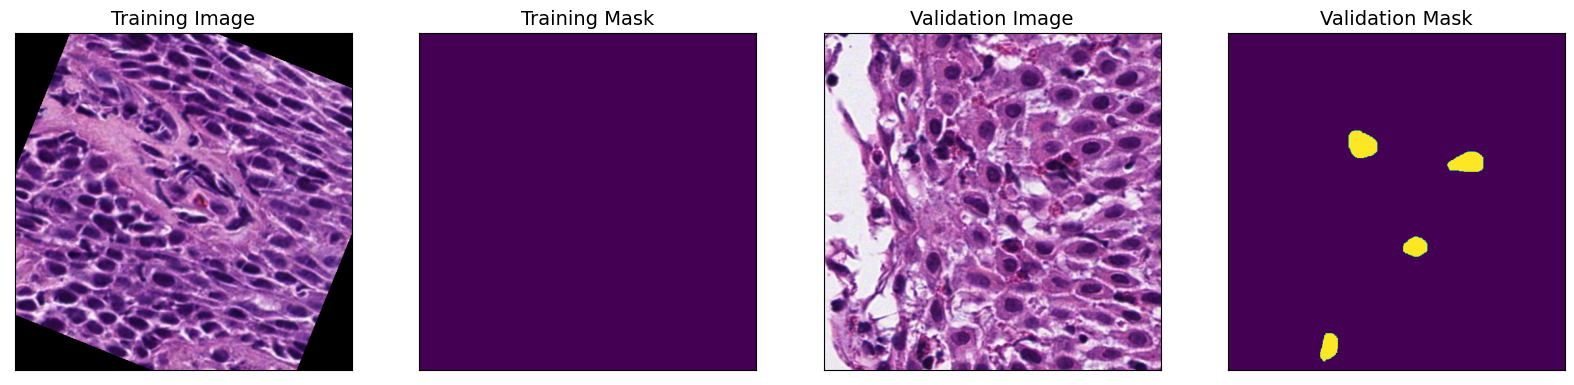

In [14]:
x, y = next(train_generator)
x_val, y_val = next(val_generator)

fig1, ax1 = plt.subplots(1,4,figsize=(20,12))
ax1[0].imshow(x[0])
ax1[0].set_xticks([])
ax1[0].set_yticks([])
ax1[0].set_title('Training Image', fontsize=14)
ax1[1].imshow(np.squeeze(y[0]))
ax1[1].set_xticks([])
ax1[1].set_yticks([])
ax1[1].set_title('Training Mask', fontsize=14)
ax1[2].imshow(x_val[0])
ax1[2].set_xticks([])
ax1[2].set_yticks([])
ax1[2].set_title('Validation Image', fontsize=14)
ax1[3].imshow(np.squeeze(y_val[0]))
ax1[3].set_xticks([])
ax1[3].set_yticks([])
ax1[3].set_title('Validation Mask', fontsize=14)

In [15]:
### Compile 
input_img = Input(shape=(512, 512, 3))
model = get_unet(input_img)
model.compile(optimizer=Adam(lr=2e-4), loss=dice_coef_loss, metrics=[dice_coef])
model.summary()

2023-05-07 13:40:49.510954: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 79035 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:07:00.0, compute capability: 8.0
2023-05-07 13:40:49.514070: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 79098 MB memory:  -> device: 1, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:90:00.0, compute capability: 8.0


Contract1
Contract2
Contract3
Contract4
Expand1
Expand2
Expand3
Expand4
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 512, 512, 32  896         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 512, 512, 32  128        ['conv2d[0][0]']                 
 alization)           

                                                                                                  
 conv2d_7 (Conv2D)              (None, 64, 64, 256)  590080      ['activation_6[0][0]']           
                                                                                                  
 batch_normalization_7 (BatchNo  (None, 64, 64, 256)  1024       ['conv2d_7[0][0]']               
 rmalization)                                                                                     
                                                                                                  
 activation_7 (Activation)      (None, 64, 64, 256)  0           ['batch_normalization_7[0][0]']  
                                                                                                  
 max_pooling2d_3 (MaxPooling2D)  (None, 32, 32, 256)  0          ['activation_7[0][0]']           
                                                                                                  
 dropout_3

                                                                                                  
 conv2d_14 (Conv2D)             (None, 256, 256, 64  73792       ['dropout_6[0][0]']              
                                )                                                                 
                                                                                                  
 batch_normalization_14 (BatchN  (None, 256, 256, 64  256        ['conv2d_14[0][0]']              
 ormalization)                  )                                                                 
                                                                                                  
 activation_14 (Activation)     (None, 256, 256, 64  0           ['batch_normalization_14[0][0]'] 
                                )                                                                 
                                                                                                  
 conv2d_15

/usr/local/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [16]:
# compute_steps_per_epoch = lambda x: int(math.ceil(1. * x / BATCH_SIZE))

# num_train_val = len(train_val_ids)
# steps_per_epoch = compute_steps_per_epoch(split_cutoff)
# val_steps = compute_steps_per_epoch(num_train_val - split_cutoff)

# earlystopper = EarlyStopping(patience=20, verbose=1)
# checkpointer = ModelCheckpoint('Models/Eo1_200.h5', verbose = 1, save_best_only=True)
# results = model.fit_generator(train_generator, validation_data=val_generator,
#                               validation_steps = val_steps,
#                               steps_per_epoch = steps_per_epoch,
#                               epochs=200, callbacks=[checkpointer,earlystopper])

/tmp/ipykernel_200681/4258242744.py:9: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  results = model.fit_generator(train_generator, validation_data=val_generator,


Epoch 1/200


2022-11-16 21:14:22.107508: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8101
2022-11-16 21:14:28.509961: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


83/83 [==============================] - ETA: 0s - loss: -0.0717 - dice_coef: 0.0724
Epoch 1: val_loss improved from inf to -0.04223, saving model to Models/Eo1_200.h5
83/83 [==============================] - 36s 276ms/step - loss: -0.0717 - dice_coef: 0.0724 - val_loss: -0.0422 - val_dice_coef: 0.0422
Epoch 2/200
83/83 [==============================] - ETA: 0s - loss: -0.1287 - dice_coef: 0.1285
Epoch 2: val_loss improved from -0.04223 to -0.05999, saving model to Models/Eo1_200.h5
83/83 [==============================] - 21s 252ms/step - loss: -0.1287 - dice_coef: 0.1285 - val_loss: -0.0600 - val_dice_coef: 0.0604
Epoch 3/200
83/83 [==============================] - ETA: 0s - loss: -0.1717 - dice_coef: 0.1714
Epoch 3: val_loss improved from -0.05999 to -0.08510, saving model to Models/Eo1_200.h5
83/83 [==============================] - 20s 246ms/step - loss: -0.1717 - dice_coef: 0.1714 - val_loss: -0.0851 - val_dice_coef: 0.0857
Epoch 4/200
83/83 [==============================] - E

Epoch 28/200
83/83 [==============================] - ETA: 0s - loss: -0.6003 - dice_coef: 0.6003
Epoch 28: val_loss did not improve from -0.64073
83/83 [==============================] - 20s 243ms/step - loss: -0.6003 - dice_coef: 0.6003 - val_loss: -0.6123 - val_dice_coef: 0.6131
Epoch 29/200
83/83 [==============================] - ETA: 0s - loss: -0.6058 - dice_coef: 0.6064
Epoch 29: val_loss did not improve from -0.64073
83/83 [==============================] - 21s 250ms/step - loss: -0.6058 - dice_coef: 0.6064 - val_loss: -0.6279 - val_dice_coef: 0.6284
Epoch 30/200
83/83 [==============================] - ETA: 0s - loss: -0.6003 - dice_coef: 0.6000
Epoch 30: val_loss improved from -0.64073 to -0.64362, saving model to Models/Eo1_200.h5
83/83 [==============================] - 20s 245ms/step - loss: -0.6003 - dice_coef: 0.6000 - val_loss: -0.6436 - val_dice_coef: 0.6436
Epoch 31/200
83/83 [==============================] - ETA: 0s - loss: -0.5903 - dice_coef: 0.5887
Epoch 31: val

Epoch 57/200
83/83 [==============================] - ETA: 0s - loss: -0.6161 - dice_coef: 0.6149
Epoch 57: val_loss improved from -0.65601 to -0.66507, saving model to Models/Eo1_200.h5
83/83 [==============================] - 20s 247ms/step - loss: -0.6161 - dice_coef: 0.6149 - val_loss: -0.6651 - val_dice_coef: 0.6644
Epoch 58/200
83/83 [==============================] - ETA: 0s - loss: -0.6429 - dice_coef: 0.6426
Epoch 58: val_loss improved from -0.66507 to -0.68046, saving model to Models/Eo1_200.h5
83/83 [==============================] - 21s 254ms/step - loss: -0.6429 - dice_coef: 0.6426 - val_loss: -0.6805 - val_dice_coef: 0.6815
Epoch 59/200
83/83 [==============================] - ETA: 0s - loss: -0.6370 - dice_coef: 0.6371
Epoch 59: val_loss did not improve from -0.68046
83/83 [==============================] - 20s 244ms/step - loss: -0.6370 - dice_coef: 0.6371 - val_loss: -0.6202 - val_dice_coef: 0.6215
Epoch 60/200
83/83 [==============================] - ETA: 0s - loss: -

83/83 [==============================] - 20s 243ms/step - loss: -0.6416 - dice_coef: 0.6420 - val_loss: -0.6679 - val_dice_coef: 0.6689
Epoch 86/200
83/83 [==============================] - ETA: 0s - loss: -0.6510 - dice_coef: 0.6514
Epoch 86: val_loss did not improve from -0.69197
83/83 [==============================] - 21s 251ms/step - loss: -0.6510 - dice_coef: 0.6514 - val_loss: -0.6623 - val_dice_coef: 0.6626
Epoch 87/200
83/83 [==============================] - ETA: 0s - loss: -0.6416 - dice_coef: 0.6416
Epoch 87: val_loss did not improve from -0.69197
83/83 [==============================] - 21s 251ms/step - loss: -0.6416 - dice_coef: 0.6416 - val_loss: -0.6172 - val_dice_coef: 0.6183
Epoch 88/200
83/83 [==============================] - ETA: 0s - loss: -0.6378 - dice_coef: 0.6382
Epoch 88: val_loss did not improve from -0.69197
83/83 [==============================] - 20s 243ms/step - loss: -0.6378 - dice_coef: 0.6382 - val_loss: -0.6587 - val_dice_coef: 0.6581
Epoch 89/200
83

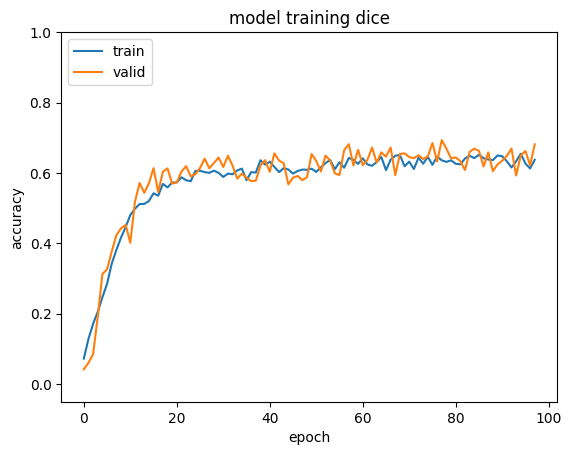

In [17]:
# summarize history for accuracy
# plt.plot(results.history['dice_coef'])
# plt.plot(results.history['val_dice_coef'])
# plt.title('model training dice')
# plt.ylabel('accuracy')
# plt.xlabel('epoch')
# plt.ylim(-.05,1)
# plt.legend(['train', 'valid'], loc='upper left')
# plt.show()

In [16]:
# When you plan to re-train model - Must run Loss Function cell
model = load_model('Models/Eo1_200.h5', compile=False)

preds_test = model.predict(X_test,verbose=1)
preds_test_t = (preds_test > 0.5).astype(np.bool)

test_dice = numpy_dice_coef(Y_test, preds_test_t)
print(test_dice)

2023-05-07 13:40:54.070955: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8101


3/4 [=====================>........] - ETA: 0s 

2023-05-07 13:41:03.535932: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


4/4 [==============================] - 13s 246ms/step
0.6941389873981331


/tmp/ipykernel_141046/1290338544.py:5: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  preds_test_t = (preds_test > 0.5).astype(np.bool)


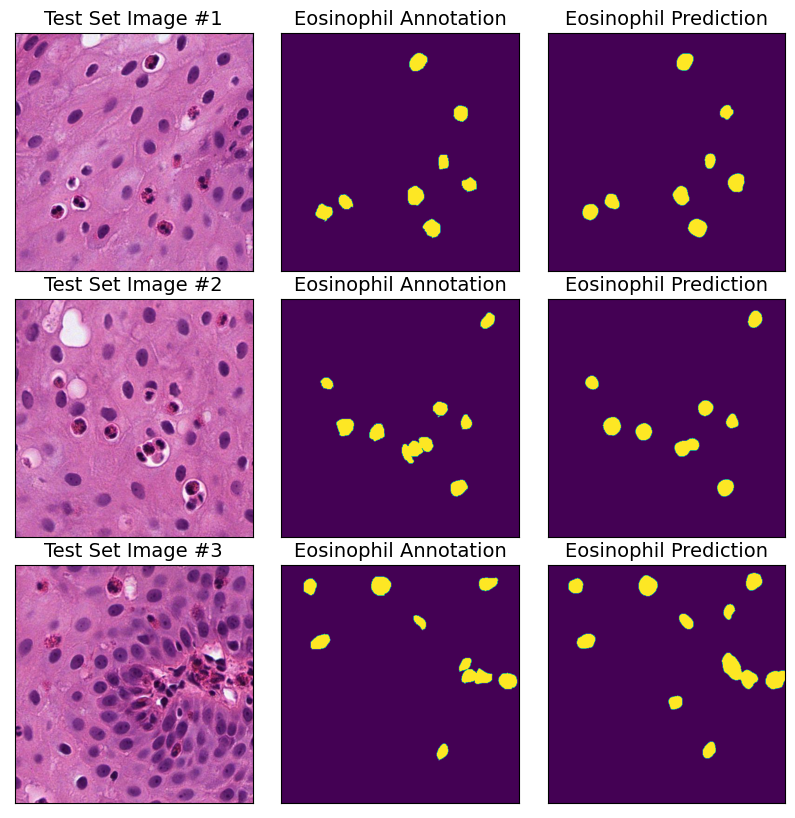

In [18]:
# Perform a sanity check on some random validation samples
ix_1 = 14 # change as necessary
ix_2 = ix_1 + 1
ix_3 = ix_2 + 1

fig1, ax1 = plt.subplots(3,3,figsize=(10,10))
ax1[0,0].imshow(np.squeeze(X_test[ix_1]))
ax1[0,0].set_title('Test Set Image #1', fontsize=14)
ax1[0,0].set_xticks([])
ax1[0,0].set_yticks([])
ax1[0,1].imshow(np.squeeze(Y_test[ix_1]))
ax1[0,1].set_title('Eosinophil Annotation', fontsize=14)
ax1[0,1].set_xticks([])
ax1[0,1].set_yticks([])
ax1[0,2].imshow(np.squeeze(preds_test_t[ix_1]))
ax1[0,2].set_title('Eosinophil Prediction', fontsize=14)
ax1[0,2].set_xticks([])
ax1[0,2].set_yticks([])

ax1[1,0].imshow(np.squeeze(X_test[ix_2]))
ax1[1,0].set_title('Test Set Image #2', fontsize=14)
ax1[1,0].set_xticks([])
ax1[1,0].set_yticks([])
ax1[1,1].imshow(np.squeeze(Y_test[ix_2]))
ax1[1,1].set_title('Eosinophil Annotation', fontsize=14)
ax1[1,1].set_xticks([])
ax1[1,1].set_yticks([])
ax1[1,2].imshow(np.squeeze(preds_test_t[ix_2]))
ax1[1,2].set_title('Eosinophil Prediction', fontsize=14)
ax1[1,2].set_xticks([])
ax1[1,2].set_yticks([])
                
ax1[2,0].imshow(np.squeeze(X_test[ix_3]))
ax1[2,0].set_title('Test Set Image #3', fontsize=14)
ax1[2,0].set_xticks([])
ax1[2,0].set_yticks([])
ax1[2,1].imshow(np.squeeze(Y_test[ix_3]))
ax1[2,1].set_title('Eosinophil Annotation', fontsize=14)
ax1[2,1].set_xticks([])
ax1[2,1].set_yticks([])
ax1[2,2].imshow(np.squeeze(preds_test_t[ix_3]))
ax1[2,2].set_title('Eosinophil Prediction', fontsize=14)
ax1[2,2].set_xticks([])
ax1[2,2].set_yticks([])
               
plt.subplots_adjust(wspace=0.1, hspace=0.12) 
plt.savefig('preds.png')

In [19]:
num_test = 100

test_counts = np.zeros(num_test, dtype=np.uint8)
pred_test_count = np.zeros(num_test, dtype=np.uint8)
for i in range(num_test):
    mask = remove_small_objects(label(Y_test[i]),200)
    labels, count = label(distance_transform_edt(mask) > 8, return_num = True)
    test_counts[i] =  count
    mask = remove_small_objects(label(preds_test_t[i]),200)
    labels, count = label(distance_transform_edt(mask) > 8, return_num = True)
    pred_test_count[i] = count

/usr/local/lib/python3.9/site-packages/skimage/_shared/utils.py:157: UserWarning: Only one label was provided to `remove_small_objects`. Did you mean to use a boolean array?
  return func(*args, **kwargs)


In [20]:
features = pd.DataFrame()
features['file_name'] = test_ids
features['final_counts'] = pred_test_count
features.head()

,file_name,final_counts
0,E-116_5_130049_55809.jpg,21
1,E-116_5_130049_56321.jpg,23
2,E-116_5_130561_55809.jpg,24
3,E-116_5_130561_56321.jpg,27
4,E-116_5_131585_62465.jpg,32


Equation: y = 0.830x + (2.513)
Corr = 0.838


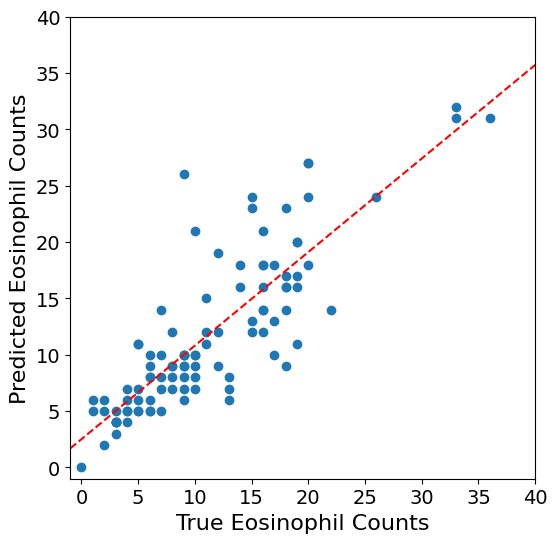

In [21]:
plt.rcParams['figure.figsize'] = [6, 6]
plt.plot(test_counts,pred_test_count,'o')
z = np.polyfit(test_counts,pred_test_count,1)
p = np.poly1d(z)
plt.plot(np.arange(-1,45),p(np.arange(-1,45)),"r--")
#plt.title("Test Set Cell Counts", fontsize=16)
plt.xlabel("True Eosinophil Counts", fontsize=16)
plt.ylabel("Predicted Eosinophil Counts", fontsize=16)
plt.xlim(-1,40)
plt.ylim(-1,40)
#plt.xaxis.major_locator(MaxNlocator(integer=True))
# the line equation:
print("Equation: y = %.3fx + (%.3f)"%(z[0],z[1]))
print("Corr = %0.3f" %pearsonr(test_counts,pred_test_count)[0])

yint = []
#locs, labels = plt.yticks()
for each in range(0,45,5):
    yint.append(int(each))
plt.yticks(yint, fontsize=14)
plt.xticks(yint, fontsize=14)
plt.savefig('original.png')

In [22]:
# Unet 0.75
abs_true_counts = (pred_test_count.astype(int) - test_counts.astype(int))
avg_diff = np.sum(abs_true_counts) / len(abs_true_counts)
print(avg_diff)
print(avg_diff*16)
print(np.std(abs_true_counts))

0.6
9.6
4.0


([<matplotlib.axis.XTick at 0x7fda816589d0>,
 [Text(-10, 0, '−10'),
  Text(-8, 0, '−8'),
  Text(-6, 0, '−6'),
  Text(-4, 0, '−4'),
  Text(-2, 0, '−2'),
  Text(0, 0, '0'),
  Text(2, 0, '2'),
  Text(4, 0, '4'),
  Text(6, 0, '6'),
  Text(8, 0, '8'),
  Text(10, 0, '10'),
  Text(12, 0, '12'),
  Text(14, 0, '14'),
  Text(16, 0, '16'),
  Text(18, 0, '18')])

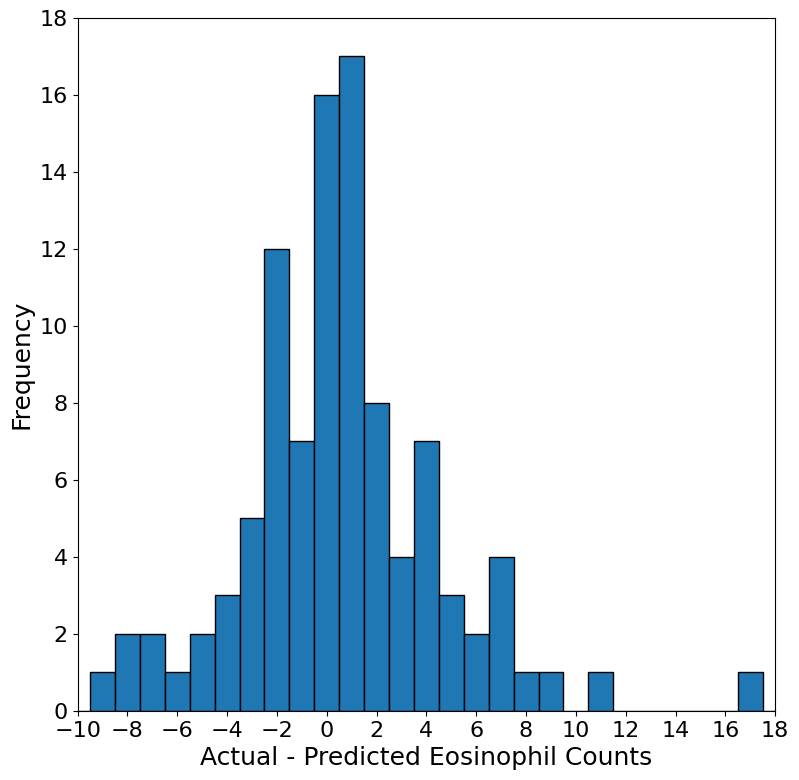

In [30]:
plt.rcParams['figure.figsize'] = [9, 9]
plt.hist(abs_true_counts,bins=range(-10,20,1),edgecolor='black',align='left')
plt.xlabel('Actual - Predicted Eosinophil Counts',fontsize=18)
plt.ylabel('Frequency',fontsize=18)
plt.xlim(-10,18)
plt.ylim(0,18)
yint = []
for each in range(0,19,2):
    yint.append(int(each))
plt.yticks(yint,fontsize=16)
xint = []
for each in range(-10,19,2):
    xint.append(int(each))
plt.xticks(xint,fontsize=16)